In [2]:
from bg_atlasapi import BrainGlobeAtlas
from preprocessing_sequencing import preprocess_sequences as ps
from znamutils import slurm_it
import pandas as pd
from final_processing import final_processing_functions as fpf
import numpy as np
import nrrd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
import pathlib
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
from sklearn.preprocessing import normalize
import ast
import seaborn as sb
import pickle
import warnings
from scipy import stats
from matplotlib.patches import Rectangle
import scipy
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit
from scipy.stats import ks_2samp
from scipy.stats import ttest_rel, wilcoxon, sem
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from matplotlib import rcParams
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "Arial"
import figure_formatting as ff
warnings.filterwarnings('ignore')
%matplotlib inline

/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/flexiznam/schema/sequencing_data.py:11: UserWarning: Could not find `sequencing_extensions` in config. Please update config file
  class SequencingData(Dataset):


In [3]:
def add_prefix_to_index(df, prefix):
    df = df.copy()  
    df.index = [f"{prefix}_{idx}" for idx in df.index]
    return df
index_adj_combined_dict = {}

In [4]:
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
combined_dict = {}
area_dict = {}
for num, mouse in enumerate(mice):
    new_dict = {}
    parameters_path = (
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded.pkl")
    lcm_dir =  pathlib.Path(
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/LCM")
    area_dict[mouse] = fpf.get_area_volumes(
        barcode_table_cols=barcodes.columns,
        lcm_directory=lcm_dir, area_threshold=0,
    )
    barcodes = add_prefix_to_index(barcodes, mouse)
    new_dict['homogenous_across_cubelet'] = fpf.homog_across_cubelet(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, IT_only=True, shuffled=False)
    new_dict['homogenous_across_area'] = fpf.homog_across_area(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, IT_only=True, shuffled=False)
    new_dict['area_is_main']= fpf.area_is_main(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, IT_only=True, shuffled=False)
    new_dict['max_counts'] = barcodes.max(axis=1)
    combined_dict[mouse] = new_dict


In [5]:
analysis_names =['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main']
all_mice = {}
for i, key in enumerate(analysis_names):
    # common_columns = set(combined_dict['FIAA45.6a'][key].columns).intersection(combined_dict['FIAA45.6d'][key].columns)
    # all_mice[key] = pd.concat([combined_dict['FIAA45.6a'][key][common_columns], combined_dict['FIAA45.6d'][key][common_columns]], ignore_index=False)
    common_columns = set(combined_dict['FIAA45.6a'][key].columns).intersection(
    set(combined_dict['FIAA45.6d'][key].columns)
).intersection(
    set(combined_dict['FIAA55.4d'][key].columns)
)
    all_mice[key] = pd.concat([combined_dict['FIAA45.6a'][key][common_columns], combined_dict['FIAA45.6d'][key][common_columns], combined_dict['FIAA55.4d'][key][common_columns]], ignore_index=False)
    

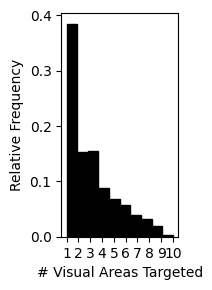

In [5]:
key='homogenous_across_cubelet'
visual_areas = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
vis_adj =[vis for vis in visual_areas if vis in all_mice[key].columns]
vis_proj = all_mice[key][all_mice[key][vis_adj].astype(bool).sum(axis=1)>0]
#data = vis_proj[vis_adj].astype(bool).sum(axis=1).value_counts()
data = vis_proj[vis_adj].astype(bool).sum(axis=1)
fig, ax = plt.subplots(figsize=(2, 3))  
ax.hist(data, bins=10, weights=np.ones_like(data) / len(data), color='black',edgecolor='black')
ax.set_xticks(np.arange(min(data), max(data) + 1, 1))
ax.set_xlabel('# Visual Areas Targeted')
ax.set_ylabel('Relative Frequency')
plt.tight_layout()
plt.show()
max_counts_list = [data["max_counts"] for data in combined_dict.values()]

# Concatenate all 'max_counts' dataframes
concatenated_max_counts = pd.concat(max_counts_list, ignore_index=False)
max_counts = concatenated_max_counts.loc[vis_proj[vis_adj].index]

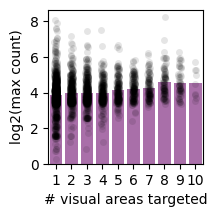

In [6]:
#supp figure showing how max cubelet barcode count per barcode changes with number of visual areas targeted
plt.figure(figsize=(2, 2)) 
df = pd.DataFrame({"x": data, "y": np.log2(max_counts)})
sb.barplot(x="x", y="y", data=df, alpha=0.6, color="purple", ci=None)

sb.stripplot(x="x", y="y", data=df, color="black", alpha=0.1, jitter=True)
plt.xlabel("# visual areas targeted")
plt.ylabel("log2(max count)")
plt.show()


In [7]:
# key = 'homogenous_across_cubelet'
# freq_df = pd.DataFrame(index=mice, columns=visual_areas)
# for mouse in mice:
#     df_to_look = combined_dict[mouse][key].astype(bool).astype(int)
#     for area in visual_areas:
#         freq_df.loc[mouse, area] = df_to_look[area].mean()


In [7]:
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
layers = ['upper', 'lower']
mouse_layer_dict = {}
for num, mouse in enumerate(mice):
    new_dict = {}
    parameters_path = (
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded_with_source.pkl")
    parameters = fpf.load_parameters(directory=parameters_path)
    sample_vol_and_regions = pd.read_pickle(pathlib.Path(parameters['lcm_directory'])/'sample_vol_and_regions.pkl')
    sample_vol_and_regions['fractions'] = sample_vol_and_regions['breakdown'].apply(ast.literal_eval)
    sample_vol_and_regions['regions'] = sample_vol_and_regions['regions'].apply(ast.literal_eval)
    AUDp_containing = sample_vol_and_regions[sample_vol_and_regions['main']=='AUDp']['ROI Number'].to_list()
    AUDp_containing = [sample for sample in AUDp_containing if sample in barcodes.columns]
    for layer in layers:
        area_dict = {}
        barcodes_new = barcodes[barcodes.idxmax(axis=1).isin(parameters[f'{layer}_layer'])].drop(columns=AUDp_containing)
        barcodes_new = barcodes_new[
            (barcodes_new[[f for f in parameters['cortical_samples'] if f in barcodes_new.columns]].astype(bool).sum(axis=1) > 0) &
            (barcodes_new[[s for s in parameters['tectum_samples'] if s in barcodes_new.columns]].astype(bool).sum(axis=1) == 0) &
            (barcodes_new[[s for s in parameters['thalamus_samples'] if s in barcodes_new.columns]].astype(bool).sum(axis=1) == 0)
        ]
        area_dict['area_is_main'] = fpf.area_is_main(parameters_path=parameters_path, barcode_matrix = barcodes_new, cortical=True, shuffled=False)
       # missing_cols = set(all_mice[key].columns) - set(area_dict['area_is_main'].columns) #since there is some zero values for regions that are looked at
        #for col in missing_cols:
        #    area_dict['area_is_main'][col] = 0
        area_dict['homogenous_across_cubelet'] = fpf.homog_across_cubelet(parameters_path=parameters_path, barcode_matrix = barcodes_new, cortical=True, IT_only=True, shuffled=False)
        area_dict['homogenous_across_area'] = fpf.homog_across_area(parameters_path=parameters_path, barcode_matrix = barcodes_new, cortical=True, IT_only=True, shuffled=False)
        new_dict[f'{layer}_layer'] = area_dict
        # print(f"Creating barcodes for {layer} layer in {mouse}")
        # print(area_dict['homogenous_across_area'])
    
    mouse_layer_dict[mouse] = new_dict


In [8]:
def add_mouse_layer(df, mouse_label, layer_label):
    df['Mouse'] = mouse_label
    df['Layer'] = layer_label
    return df
visual_areas = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
key = 'homogenous_across_cubelet'
new_layer_dict = {}
for mouse in mice:
    mini_dict = {}
    for layer in layers:
        mini_dict[f'{layer}_layer'] = mouse_layer_dict[mouse][f'{layer}_layer'][key][visual_areas].astype(bool).astype(int)
        mini_dict[f'{layer}_layer'] = add_mouse_layer(mini_dict[f'{layer}_layer'], mouse, layer)
    concatenated_df = pd.concat(mini_dict.values(), axis=0, ignore_index=False)
    new_layer_dict[mouse] = concatenated_df
combined_df = pd.concat(new_layer_dict.values(), axis=0, ignore_index=False)
combined_df = combined_df.dropna(axis=1, how='any')

In [9]:

results = {}
df = combined_df.melt(id_vars=['Mouse', 'Layer'], var_name='Area', value_name='Projection')
pval_df = pd.DataFrame(index=visual_areas, columns=['p_value', 'OR'])
for area in visual_areas:
    df_area = df[df['Area'] == area]
    model = smf.logit('Projection ~ Layer + Mouse', data=df_area).fit(disp=False)
    results = model.summary2().tables[1]
    pval_df.loc[area, 'p_value'] = results.loc['Layer[T.upper]', 'P>|z|']
    pval_df.loc[area, 'OR'] = np.exp(results.loc['Layer[T.upper]', 'Coef.'])

pval_df['p_value_corrected'] = pval_df['p_value']*len(pval_df)
summary_df = pd.DataFrame(index = mice, columns = visual_areas)
for mouse in mice:
    dff = new_layer_dict[mouse]
    for area in visual_areas:
        freq_upper = dff[dff['Layer']=='upper'][area].mean()
        freq_lower = dff[dff['Layer']=='lower'][area].mean()
        summary_df.loc[mouse, area] = freq_upper/freq_lower
visual_areas = summary_df.columns


In [10]:
pval_df = fpf.convert_matrix_names(pval_df)
summary_df = fpf.convert_matrix_names(summary_df)
new_order = ['LM', 'LI', 'POR', 'P', 'AL', 'V1', 'AM', 'A', 'PM', 'RL']
summary_df = summary_df[new_order]

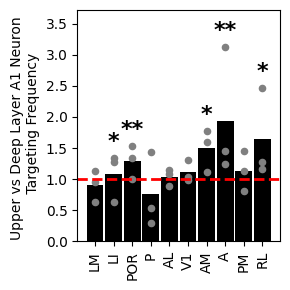

In [11]:
plt.figure(figsize=(3, 3))  # Adjusted figure size for better layout
area_means = summary_df.mean(axis=0)
max_value = summary_df.max().max()
sb.barplot(x=new_order, y=area_means, color='black', ci=None, width=0.9, zorder=1)
for i, area in enumerate(new_order):
    for mouse in summary_df.index:
        plt.scatter(
            i, 
            summary_df.loc[mouse, area], 
            color='grey', s=20, zorder=2
        )
heights = []
for i, area in enumerate(new_order):
    asterisk_height = summary_df[area].max() + 0.1  
    p_value = pval_df.loc[area, 'p_value_corrected']  
    if p_value <= 0.001:
        asterisk = '***'
    elif p_value <= 0.01:
        asterisk = '**'
    elif p_value <= 0.05:
        asterisk = '*'
    else:
        asterisk = None  # No asterisk if p > 0.05
    
    if asterisk:  # Add asterisk if significance is present
        plt.text(
            i,  
            asterisk_height,
            asterisk, 
            ha='center', va='bottom', fontsize=16, color='black', weight='bold'
        )
        heights.append(asterisk_height)
plt.axhline(y=1, color='red', linestyle='--', linewidth=2)
plt.xticks(rotation=90)
plt.ylim(0, np.max(heights) + 0.5) 

plt.ylabel('Upper vs Deep Layer A1 Neuron \n Targeting Frequency')
plt.tight_layout()
plt.show()

In [7]:
# HVA_colors : {'V1': '#6E665E', 
# 'POR': '#79B855', #4C9E57
# 'LI': '#AAC255', #79B855
# 'P': '#4C9E57', #AAC255
# 'LM' : '#D6C759',
# 'AL' : '#C7A859',                
# 'RL' : '#F0BE7E',
# 'A': '#D78257',
# 'AM': '#C2543C',
# 'PM': '#D7716C',                                                  
# 'OUT': 'lightgray'}

In [6]:
# from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
# mcc = MouseConnectivityCache()
# structure_tree = mcc.get_structure_tree()
# rsp = mcc.get_reference_space()
# a1_dist_dict = {}
# visual_areas = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
# HVA_colors = {'V1': '#6E665E', 
# 'POR': '#79B855', #4C9E57
# 'LI': '#AAC255', #79B855
# 'P': '#4C9E57', #AAC255
# 'LM' : '#D6C759',
# 'AL' : '#C7A859',                
# 'RL' : '#F0BE7E',
# 'A': '#D78257',
# 'AM': '#C2543C',
# 'PM': '#D7716C',                                                  
# 'Other': 'lightgray'}
# HVA_colors_updated = {'VISp': '#6E665E', 
# 'VISpor': '#79B855', #4C9E57
# 'VISli': '#AAC255', #79B855
# 'VISpl': '#4C9E57', #AAC255
# 'VISl' : '#D6C759',
# 'VISal' : '#C7A859',                
# 'VISrl' : '#F0BE7E',
# 'VISa': '#D78257',
# 'VISam': '#C2543C',
# 'VISpm': '#D7716C'}



# structure = structure_tree.get_structures_by_acronym(['AUDp'])
# structure_id = structure[0]['id']
# mask = rsp.make_structure_mask([structure_id], direct_only=False)
# A1_coord = (np.mean(np.where(mask == 1)[0]), np.mean(np.where(mask == 1)[1]), np.mean(np.where(mask == 1)[2]))

# fig, ax = plt.subplots(1, 1, figsize=(3, 2.5))  # Use a single plot for key[2]


# # legend_elements = [Line2D([0], [0], marker='o', color='w', label='Visual Areas',
# #                           markerfacecolor='forestgreen', markersize=8, linestyle='None'),
# #                    Line2D([0], [0], color='red', lw=2, linestyle='--', label='Exponential Fit')]
# fit_legend_element = Line2D([0], [0], color='dimgrey', lw=2, linestyle='--', label='Exponential\nFit')


# visual_legend_elements = [
#     Line2D([0], [0], marker='o', color='w', label=area,
#            markerfacecolor=color, markersize=8, linestyle='None')
#     for area, color in HVA_colors.items()
# ]
# legend_elements = visual_legend_elements + [fit_legend_element]

# def exponential_decay(x, a, b):
#     return a * np.exp(-b * x)


# key_to_plot = analysis_names[0]  

# areas = all_mice[key_to_plot].columns
# areas = areas.drop(['Contra', 'AUDp'])
# vis_adj = [vis for vis in visual_areas if vis in all_mice[key_to_plot].columns]

# distance_from_a1 = pd.DataFrame(index=areas, columns=['dist'])
# for col in areas:
#     structure = structure_tree.get_structures_by_acronym([col])
#     structure_id = structure[0]['id']
#     mask = rsp.make_structure_mask([structure_id], direct_only=False)
#     vis_coord = np.mean(np.where(mask == 1)[0]), np.mean(np.where(mask == 1)[1]), np.mean(np.where(mask == 1)[2])
#     distance_from_a1.loc[col] = np.linalg.norm(np.array(A1_coord) - np.array(vis_coord)) * 25

# a1_dist_dict[key_to_plot] = distance_from_a1
# freq_df = pd.DataFrame(columns=areas, index=mice)
# for mouse in mice:
#     freq_df.loc[mouse] = combined_dict[mouse][key_to_plot][areas].astype(bool).sum(axis=0) / len(combined_dict[mouse][key_to_plot])

# if isinstance(a1_dist_dict[key_to_plot], pd.DataFrame):
#     distances = pd.Series(a1_dist_dict[key_to_plot].iloc[:, 0], index=areas)
# else:
#     distances = pd.Series(a1_dist_dict[key_to_plot], index=areas)

# distances = pd.to_numeric(distances, errors='coerce')
# means = pd.to_numeric(freq_df.mean(), errors='coerce')
# errors = pd.to_numeric(freq_df.std(), errors='coerce')

# means = pd.Series(means, index=areas)
# errors = pd.Series(errors, index=areas)

# if len(distances) > 1 and (means > 0).any() and not distances.isnull().any() and not means.isnull().any():
#     try:
#         # Fit the exponential decay curve
#         params, _ = curve_fit(exponential_decay, distances.values, means.values, p0=(max(means), 0.001))

#         # Generate a smooth curve for plotting
#         fitted_x = np.linspace(min(distances), max(distances), 100)
#         fitted_y = exponential_decay(fitted_x, *params)

#         # Plot the fitted exponential decay curve
#         ax.plot(fitted_x, fitted_y, color='dimgrey', linestyle='--',
#                 label=f'Exponential Fit: $y = {params[0]:.2f}e^{{-{params[1]:.4f}x}}$')

#         # Kolmogorov-Smirnov test (KS test) for goodness-of-fit
#         fitted_values = exponential_decay(distances.values, *params)  # Fitted values at the empirical data points
#         ks_stat, ks_p_value = ks_2samp(means.values, fitted_values)
#         print(f"KS Statistic: {ks_stat}, p-value: {ks_p_value}")
#         # ax.text(0.05, 0.95, f'KS p-value: {ks_p_value:.4f}', transform=ax.transAxes, fontsize=10,
#         #         verticalalignment='top')

#     except Exception as e:
#         print(f"Error fitting exponential curve for key {key_to_plot}: {e}")


# # for area in areas:
# #     color = 'forestgreen' if area in vis_adj else 'gray'  # Forest green for vis_adj areas, gray otherwise
# #     ax.errorbar(distances[area], means[area], yerr=errors[area], fmt='o', ecolor='black',
# #                 mfc=color, mec=color, capsize=5)
# for area in areas:
#     # Use the HVA_colors dictionary if the area exists, otherwise default to light gray
#     color = HVA_colors_updated.get(area, 'lightgrey')  # Use the color from the dictionary or default to light gray
#     ax.errorbar(distances[area], means[area], yerr=errors[area], fmt='o', ecolor='black',
#                 mfc=color, mec=color, capsize=5)

# ax.set_ylabel('Frequency of Targeting')
# ax.set_xlabel('Distance from A1 (µm)')

# #fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.95, 0.9), fontsize=10)
# fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize=10)
# plt.tight_layout()
# plt.show()


In [7]:
# from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
# mcc = MouseConnectivityCache()
# structure_tree = mcc.get_structure_tree()
# rsp = mcc.get_reference_space()

# # Get the structure ID and coordinates for AUDp (A1 region)
# structure = structure_tree.get_structures_by_acronym(['AUDp'])
# structure_id = structure[0]['id']
# mask = rsp.make_structure_mask([structure_id], direct_only=False)
# A1_coord = (np.mean(np.where(mask == 1)[0]), np.mean(np.where(mask == 1)[1]), np.mean(np.where(mask == 1)[2]))

# # Prepare subplots
# fig, ax = plt.subplots(1, 1, figsize=(3,2.5))  # Use a single plot for key[2]

# # Create custom legend elements for visual areas and exponential fit
# legend_elements = [Line2D([0], [0], color='dimgrey', lw=2, linestyle='--', label='Exponential Fit')]


# def exponential_decay(x, a, b):
#     return a * np.exp(-b * x)

# key_to_plot = analysis_names[0] 

# areas = all_mice[key_to_plot].columns
# areas = areas.drop(['Contra', 'AUDp'])
# vis_adj = [vis for vis in visual_areas if vis in all_mice[key_to_plot].columns]

# a1_dist_dict = {}
# distance_from_a1 = pd.DataFrame(index=areas, columns=['dist'])
# for col in areas:
#     structure = structure_tree.get_structures_by_acronym([col])
#     structure_id = structure[0]['id']
#     mask = rsp.make_structure_mask([structure_id], direct_only=False)
#     vis_coord = np.mean(np.where(mask == 1)[0]), np.mean(np.where(mask == 1)[1]), np.mean(np.where(mask == 1)[2])
#     distance_from_a1.loc[col] = np.linalg.norm(np.array(A1_coord) - np.array(vis_coord)) * 25

# a1_dist_dict[key_to_plot] = distance_from_a1

# freq_df = pd.DataFrame(columns=areas, index=mice)
# for mouse in mice:
#     #freq_df.loc[mouse] = combined_dict[mouse][key_to_plot][areas].replace(0, np.nan).mean(axis=0)
#     freq_df.loc[mouse] = combined_dict[mouse][key_to_plot][areas].where(combined_dict[mouse][key_to_plot][areas] > 0).mean(axis=0)
# if isinstance(a1_dist_dict[key_to_plot], pd.DataFrame):
#     distances = pd.Series(a1_dist_dict[key_to_plot].iloc[:, 0], index=areas)
# else:
#     distances = pd.Series(a1_dist_dict[key_to_plot], index=areas)

# distances = pd.to_numeric(distances, errors='coerce')
# means = pd.to_numeric(freq_df.mean(), errors='coerce')
# errors = pd.to_numeric(freq_df.std(), errors='coerce')
# means = pd.Series(means, index=areas)
# errors = pd.Series(errors, index=areas)
# if len(distances) > 1 and (means > 0).any() and not distances.isnull().any() and not means.isnull().any():
#     try:
#         params, _ = curve_fit(exponential_decay, distances.values, means.values, p0=(max(means), 0.001))
#         fitted_x = np.linspace(min(distances), max(distances), 100)
#         fitted_y = exponential_decay(fitted_x, *params)
#         ax.plot(fitted_x, fitted_y, color='dimgrey', linestyle='--',
#                 label=f'Exponential Fit: $y = {params[0]:.2f}e^{{-{params[1]:.4f}x}}$')

#     except Exception as e:
#         print(f"Error fitting exponential curve for key {key_to_plot}: {e}")
# # mfc=color, mec=color, capsize=5)
# for area in areas:
#     color = HVA_colors_updated.get(area, 'lightgrey')  
#     ax.errorbar(distances[area], means[area], yerr=errors[area], fmt='o', ecolor='black',
#                 mfc=color, mec=color, capsize=5)

# ax.set_ylabel('Mean Projection Strength')
# ax.set_xlabel('Distance from A1 (µm)')
# fitted_values = exponential_decay(distances.values, *params) 
# ks_stat, ks_p_value = ks_2samp(means.values, fitted_values)
# print(f"KS Statistic: {ks_stat}, p-value: {ks_p_value}")
# fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.95, 0.85), fontsize=10)
# plt.tight_layout()
# plt.show()

KS Statistic: 0.15384615384615385, p-value: 0.9260194717268708
KS Statistic: 0.2692307692307692, p-value: 0.30712304007383906


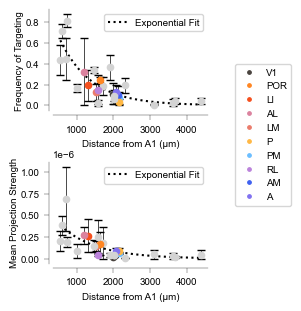

In [9]:
mcc = MouseConnectivityCache()
structure_tree = mcc.get_structure_tree()
rsp = mcc.get_reference_space()
plt.rcParams["font.size"] = 7
a1_dist_dict = {}
visual_areas = ['VISli', 'VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
HVA_colors_updated = ff.get_colour_dict(allen_nomenclature=True)
# HVA_colors_updated = {
#     'VISp': '#6E665E', 'VISpor': '#79B855', 'VISli': '#AAC255', 'VISpl': '#4C9E57', 
#     'VISl': '#D6C759', 'VISal': '#C7A859', 'VISrl': '#F0BE7E', 'VISa': '#D78257', 
#     'VISam': '#C2543C', 'VISpm': '#D7716C'
# }

structure = structure_tree.get_structures_by_acronym(['AUDp'])
structure_id = structure[0]['id']
mask = rsp.make_structure_mask([structure_id], direct_only=False)
A1_coord = (np.mean(np.where(mask == 1)[0]), np.mean(np.where(mask == 1)[1]), np.mean(np.where(mask == 1)[2]))

fig, axes = plt.subplots(2, 1, figsize=(2, 3.3), sharex=True)

plt.subplots_adjust(hspace=0.5)  # Increases vertical spacing between subplots

def exponential_decay(x, a, b):
    return a * np.exp(-b * x)

key_to_plot = 'homogenous_across_cubelet'
areas = all_mice[key_to_plot].columns.drop(['Contra', 'AUDp'])
vis_adj = [vis for vis in visual_areas if vis in all_mice[key_to_plot].columns]

distance_from_a1 = pd.DataFrame(index=areas, columns=['dist'])
for col in areas:
    structure = structure_tree.get_structures_by_acronym([col])
    structure_id = structure[0]['id']
    mask = rsp.make_structure_mask([structure_id], direct_only=False)
    vis_coord = np.mean(np.where(mask == 1)[0]), np.mean(np.where(mask == 1)[1]), np.mean(np.where(mask == 1)[2])
    distance_from_a1.loc[col] = np.linalg.norm(np.array(A1_coord) - np.array(vis_coord)) * 25

a1_dist_dict[key_to_plot] = distance_from_a1

freq_df = pd.DataFrame(columns=areas, index=mice)
freq_df_strength = pd.DataFrame(columns=areas, index=mice)
for mouse in mice:
    freq_df.loc[mouse] = combined_dict[mouse][key_to_plot][areas].astype(bool).sum(axis=0) / len(combined_dict[mouse][key_to_plot])
    freq_df_strength.loc[mouse] = combined_dict[mouse][key_to_plot][areas].where(combined_dict[mouse][key_to_plot][areas] > 0).mean(axis=0)
distances = pd.Series(a1_dist_dict[key_to_plot].iloc[:, 0], index=areas)
distances = pd.to_numeric(distances, errors='coerce')
for which_one, which_type in enumerate([freq_df, freq_df_strength]):
    means = pd.to_numeric(which_type.mean(), errors='coerce')
    errors = pd.to_numeric(which_type.std(), errors='coerce')

    if len(distances) > 1 and (means > 0).any() and not distances.isnull().any() and not means.isnull().any():
        try:
            params, _ = curve_fit(exponential_decay, distances.values, means.values, p0=(max(means), 0.001))
            fitted_x = np.linspace(min(distances), max(distances), 100)
            fitted_y = exponential_decay(fitted_x, *params)
            what_plot = axes[which_one].plot(fitted_x, fitted_y, color='k', linestyle='dotted', label='Exponential Fit')
            
            fitted_values = exponential_decay(distances.values, *params)
            ks_stat, ks_p_value = ks_2samp(means.values, fitted_values)
            print(f"KS Statistic: {ks_stat}, p-value: {ks_p_value}")

        except Exception as e:
            print(f"Error fitting exponential curve for key {key_to_plot}: {e}")

    for area in areas:
        color = HVA_colors_updated.get(area, 'lightgrey')
        axes[which_one].errorbar(distances[area], means[area], yerr=errors[area], fmt='o', color='black', mfc=color, mec=color, capsize=3, markersize=4.5, elinewidth=0.5)
        # axes[1].errorbar(distances[area], means[area], yerr=errors[area], fmt='o', ecolor='black', mfc=color, mec=color, capsize=5)
    ff.myPlotSettings_splitAxis(fig=what_plot, ax=axes[which_one], ytitle= 'y title', xtitle='Distance from A1 (µm)', title='', mySize =7)
axes[0].set_ylabel('Frequency of Targeting')
axes[1].set_ylabel('Mean Projection Strength')
axes[0].tick_params(labelbottom=True)
convert_dict = {
    "VISp": "V1",
    "VISpor": "POR",
    "VISli": "LI",
    "VISal": "AL",
    "VISl": "LM",
    "VISpl": "P",
    "VISpm": "PM",
    "VISrl": "RL",
    "VISam": "AM",
    "VISa": "A",
}

visual_legend_elements = [
    Line2D([0], [0], marker='o', color='w', 
           label=convert_dict.get(area, area),  # Convert name using dictionary
           markerfacecolor=color, markersize=4.5, linestyle='None')
    for area, color in HVA_colors_updated.items()
]

fig.legend(handles=visual_legend_elements, loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize=7, prop={'family': 'Arial'})
# visual_legend_elements = [
#     Line2D([0], [0], marker='o', color='w', label=area, markerfacecolor=color, markersize=8, linestyle='None')
#     for area, color in HVA_colors_updated.items()
# ]

# fig.legend(handles=visual_legend_elements, loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize=10)

for ax in axes:
    ax.legend(loc='upper right', fontsize=7)

plt.show()

In [1]:
import matplotlib.font_manager as fm
available_fonts = [f.name for f in fm.fontManager.ttflist]
print("Is Arial available?", "Arial" in available_fonts)

Is Arial available? True


In [7]:
available_fonts = [f.name for f in fm.fontManager.ttflist]

In [10]:
from matplotlib import rcParams
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "Arial"

In [1]:
import figure_formatting as ff

In [2]:
ff.print_sys()

/camp/home/turnerb/.conda/envs/MAPseq_processing/bin/python


In [6]:
import sys
print(sys.executable) 

/camp/home/turnerb/.conda/envs/MAPseq_processing/bin/python
